In [76]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib
from functools import partial


import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

from jax.config import config
config.update("jax_enable_x64", True)

In [86]:
## import modules
import preconditioner as precond
import conjugate_gradient as cg
import pivoted_cholesky as pc
# import pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import calc_logdet
import calc_trace
import mmm
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(mmm)
reload()

In [3]:
import warnings
warnings.filterwarnings("always")

In [4]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
from stopro.GP.kernels import define_kernel
# from stopro.solver.optimizers import optimize_by_adam
from stopro.data_handler.data_handle_module import *

In [5]:
project_name = 'test'
simulation_name = 'data'

In [6]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [7]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [8]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)

In [9]:
cov_scale = 0.0
length = 2.3
init = jnp.array(
    [
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
    ]
)
right_matrix = jax.random.normal(
    jax.random.PRNGKey(0), (params_prepare["num_points"]["training"]["sum"], 1)
)
K = gp_model.trainingK_all(init, r_train)
K_x_right_matrix_naive = jnp.matmul(K, right_matrix)

In [10]:
Ks = gp_model.trainingKs(init, r_train)
for i in range(len(Ks)):
    for j in list(range(len(Ks) - len(Ks[i])))[::-1]:
        Ks[i] = [Ks[j][i]] + Ks[i]

In [11]:
r1s = r_train
r2s = r_train
sec1 = gp_model.sec_tr
sec2 = gp_model.sec_tr
Kss = Ks

In [12]:
K_x_right_matrix = mmm.mmm(r_train, r_train, right_matrix, Ks, gp_model.sec_tr, gp_model.sec_tr, jiggle=0.)

In [13]:
mean_rel_error = jnp.mean(
        jnp.abs((K_x_right_matrix_naive - K_x_right_matrix) / K_x_right_matrix_naive)
)

In [14]:
jnp.min(jnp.abs(K_x_right_matrix_naive))

DeviceArray(0.05685187, dtype=float64)

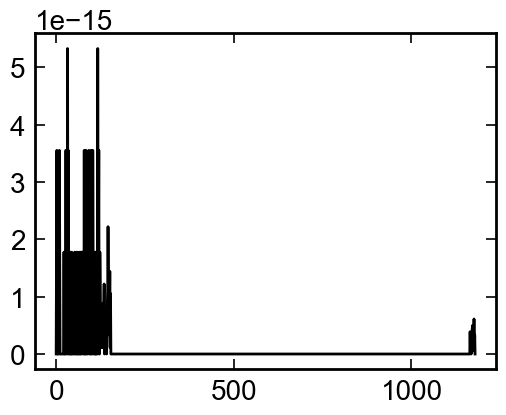

In [15]:
plt.plot(jnp.abs(K_x_right_matrix_naive - K_x_right_matrix))

In [16]:
mean_rel_error

DeviceArray(5.33600269e-17, dtype=float64)

In [16]:
cov_scale = 0.0
length = 0.0
init = jnp.array(
    [
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
    ]
)
right_matrix = jax.random.normal(
    jax.random.PRNGKey(0), (params_prepare["num_points"]["training"]["sum"], 11)
)
K = gp_model.trainingK_all(init, r_train)
K_x_right_matrix_naive = jnp.matmul(K, right_matrix)

In [17]:
Ks = gp_model.trainingKs(init, r_train)
for i in range(len(Ks)):
    for j in list(range(len(Ks) - len(Ks[i])))[::-1]:
        Ks[i] = [Ks[j][i]] + Ks[i]

In [18]:
r1s = r_train
r2s = r_train
sec1 = gp_model.sec_tr
sec2 = gp_model.sec_tr
Kss = Ks

In [19]:
K_x_right_matrix = mmm.mmm(r_train, r_train, right_matrix, Ks, gp_model.sec_tr, gp_model.sec_tr, jiggle=0.)

In [20]:
mean_rel_error = jnp.mean(
        jnp.abs((K_x_right_matrix_naive - K_x_right_matrix) / K_x_right_matrix_naive)
)

In [21]:
mean_rel_error

DeviceArray(3.8516966e-15, dtype=float64)

## with noise

In [22]:
cov_scale = 0.0
length = 0.0
init = jnp.array(
    [
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
        cov_scale,
        length,
        length,
    ]
)
right_matrix = jax.random.normal(
    jax.random.PRNGKey(0), (params_prepare["num_points"]["training"]["sum"], 11)
)
K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(K, params_model["epsilon"], noise_parameter=None)
K_x_right_matrix_naive = jnp.matmul(K, right_matrix)

In [23]:
Ks = gp_model.trainingKs(init, r_train)
for i in range(len(Ks)):
    for j in list(range(len(Ks) - len(Ks[i])))[::-1]:
        Ks[i] = [Ks[j][i]] + Ks[i]

In [24]:
r1s = r_train
r2s = r_train
sec1 = gp_model.sec_tr
sec2 = gp_model.sec_tr
Kss = Ks

In [25]:
K_x_right_matrix = mmm.mmm(r_train, r_train, right_matrix, Ks, gp_model.sec_tr, gp_model.sec_tr, jiggle=params_model["epsilon"])

In [26]:
mean_rel_error = jnp.mean(
        jnp.abs((K_x_right_matrix_naive - K_x_right_matrix) / K_x_right_matrix_naive)
)

In [27]:
mean_rel_error

DeviceArray(3.62514363e-15, dtype=float64)

## checking time

In [32]:
%%timeit
K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(K, params_model["epsilon"], noise_parameter=None)
K_x_right_matrix_naive = jnp.matmul(K, right_matrix)

1.31 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
mmm_partial = partial(mmm.mmm, r1s=r_train, r2s=r_train, Kss=Kss, sec1=gp_model.sec_tr, sec2=gp_model.sec_tr, jiggle=params_model["epsilon"])

In [38]:
%%timeit
K_x_right_matrix = mmm_partial(right_matrix=right_matrix)

9.48 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## calculate gradient

In [43]:
right_matrix = jax.random.normal(
    jax.random.PRNGKey(0), (params_prepare["num_points"]["training"]["sum"], 1)
)

In [44]:
def mmm_given_init(init):
    Ks = gp_model.trainingKs(init, r_train)
    for i in range(len(Ks)):
        for j in list(range(len(Ks) - len(Ks[i])))[::-1]:
            Ks[i] = [Ks[j][i]] + Ks[i]
    K_x_right_matrix = mmm.mmm(
        r_train, r_train, right_matrix, Ks, gp_model.sec_tr, gp_model.sec_tr, jiggle=params_model["epsilon"]
    )
    return K_x_right_matrix

In [51]:
init

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [45]:
K_x_right_matrix = mmm_given_init(init)

In [52]:
K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(K, params_model["epsilon"], noise_parameter=None)
K_x_right_matrix_naive = jnp.matmul(K, right_matrix)

In [73]:
mmm_K = mmm.setup_mmm_K(r_train, gp_model, init, params_model["epsilon"])
K_x_right_matrix = mmm_K(right_matrix=right_matrix)

In [74]:
mean_rel_error = jnp.mean(
        jnp.abs((K_x_right_matrix_naive - K_x_right_matrix) / K_x_right_matrix_naive)
)

In [75]:
mean_rel_error

DeviceArray(1.27178508e-17, dtype=float64)

In [55]:
mmm_dK = jax.jacfwd(mmm_given_init)

In [62]:
dKdtheta_x_right_matrix = mmm_dK(init)

In [58]:
dKdtheta_x_right_matrix.shape

(1180, 1, 9)

In [59]:
def calc_trainingK(theta):
    Σ = gp_model.trainingK_all(theta, r_train)
    Σ = gp_model.add_eps_to_sigma(Σ, params_model["epsilon"], noise_parameter=None)
    return Σ

In [60]:
dKdtheta = jnp.transpose(jax.jacfwd(calc_trainingK)(init), (2, 0, 1))

In [63]:
dKdtheta_x_right_matrix_ref = jnp.matmul(dKdtheta, right_matrix)

In [65]:
dKdtheta_x_right_matrix = jnp.transpose(dKdtheta_x_right_matrix, (2, 0, 1))

In [67]:
jnp.mean(jnp.abs(dKdtheta_x_right_matrix-dKdtheta_x_right_matrix_ref))

DeviceArray(1.68101565e-17, dtype=float64)

In [131]:
importlib.reload(mmm)

<module 'mmm' from '/home/ogawa_kenta/research/M2/bbmm_implementation/duplication_of_bbmm/mmm.py'>

In [132]:
mmm_dKdtheta = mmm.setup_mmm_dKdtheta(r_train, gp_model, init, params_model["epsilon"])

In [133]:
dKdtheta_new = mmm_dKdtheta(right_matrix=right_matrix)

In [135]:
jnp.mean(jnp.abs(jnp.transpose(dKdtheta_new, (2, 0, 1))-dKdtheta_x_right_matrix_ref))

DeviceArray(1.68101565e-17, dtype=float64)

In [136]:
dKdtheta.shape

(9, 1180, 1180)

## checking time

In [137]:
%%timeit
dKdtheta_new = mmm_dKdtheta(right_matrix=right_matrix)

23.1 s ± 493 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
%%timeit
dKdtheta = jnp.transpose(jax.jacfwd(calc_trainingK)(init), (2, 0, 1))
dKdtheta_x_right_matrix_ref = jnp.matmul(dKdtheta, right_matrix)

2.4 s ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [145]:
trainingdKs = jax.jacfwd(gp_model.trainingKs, argnums=0)

In [146]:
## カーネル自体を微分するのは難しい
dKss = trainingdKs(init, r_train)

TypeError: Value <function GPmodel2DStokesIndependent.setup_no_diffop_kernel.<locals>.Kuxux at 0x7f0c12c885e0> with type <class 'function'> is not a valid JAX type